In [73]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.svm import OneClassSVM
from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score,make_scorer,confusion_matrix,roc_curve, auc 

/Users/zhiji/anaconda/envs/Fintech/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


# 1. load dataframe from cvs files

In [97]:
path = "/Users/zhiji/Desktop/实习/ccts/黑产攻击识别/"
train = pd.read_csv(path + "atec_anti_fraud_train.csv")
test = pd.read_csv(path + "atec_anti_fraud_test_a.csv")

# 2. pre-process the data

In [122]:
#there is totally 297 features

train_labeled_raw = train[train.label != -1]
# drop all nan features
train_labeled = train_labeled_raw.fillna(0)
print(len(train_labeled_raw))
features = []
for c in train_labeled.columns:
    if c[0] == 'f':
        features.append(c)
x = train_labeled[features]
y = train_labeled.label

990006


# 3. Fit machine learning methods

In [112]:
def svm_distribution(label, classnum):
  if (classnum == 2):
    z, t = ZeroTwoFrequency(label)
    return 'Up：' + str(z) + ' Down：' + str(t)
  if (classnum == 3):
    z, o, t = ZeroOneTwoFrequency(label)
    return 'Up：' + str(z) + ' Flat: ' + str(o) + ' Down：' + str(t)
def get_stat_ocSVM(X, y,start_index, end_index, tuned_parameters, split = 0.8):
    X = X[start_index:end_index]
    y = y[start_index : end_index]
    a_train = []
    a_test =  []
    classnum = 2
    #get cleaned technical indicators
    edge = np.int(split*len(y))
    X_train, X_test, y_train, y_test = X[:edge], X[edge:],y[:edge],y[edge:]
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_nomalized = scaler.transform(X_train)
    X_test_nomalized = scaler.transform(X_test)

    clf = GridSearchCV(OneClassSVM(), tuned_parameters, cv = 5,
                  scoring = 'accuracy')
    clf.fit(X_train_nomalized, y_train)
    prediction_train = 0.5*(clf.predict(X_train_nomalized) + 1)
    prediction_test = 0.5*(clf.predict(X_test_nomalized) + 1)
    cm_train = confusion_matrix(y_train, prediction_train)
    cm_test = confusion_matrix(y_test, prediction_test)
    print(cm_train)
    print(cm_test)
    print("2 classes prediction: ", prediction_train, prediction_test)
    a_train.append(accuracy_score(y_train, prediction_train))
    a_test.append(accuracy_score(y_test, prediction_test))
#     ba_train.append(black_accuracy(y_train, prediction_train))
#     ba_test.append(black_accuracy(y_test, prediction_test))
    return pd.DataFrame({
        'confusion matrix train': cm_train,
        'confusion matrix test': cm_test
    },index = range(end_index - start_index))

def get_stat_SVM(X, y, tuned_parameters, split = 0.8):
    d_test, d_train = [], []
    a_train = []
    a_test =  []
    classnum = 2
    #get cleaned technical indicators
#     X, y = get_dataframe(name, iwl, fh, start_date, end_date,freq, classnum = classnum, method = 'SVM')
    edge = np.int(split*len(y))
    X_train, X_test, y_train, y_test = X[:edge], X[edge:],y[:edge],y[edge:]
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_nomalized = scaler.transform(X_train)
    X_test_nomalized = scaler.transform(X_test)

    clf = GridSearchCV(SVC(), tuned_parameters, cv = 5,
                  scoring = 'accuracy')
    clf.fit(X_train_nomalized, y_train)
    prediction_train = clf.predict(X_train_nomalized)
    prediction_test = clf.predict(X_test_nomalized)
    print("2 classes prediction: ", prediction_train, prediction_test)
    a_train.append(accuracy_score(y_train, prediction_train))
    a_test.append(accuracy_score(y_test, prediction_test))
#     z_train, t_train = ZeroTwoFrequency(y_train)
#     z_test, t_test = ZeroTwoFrequency(y_test)

    d_train.append(svm_distribution(y_train, classnum))
    d_test.append(svm_distribution(y_test, classnum))

    return pd.DataFrame({
      '训练分布':d_train,
      '测试分布':d_test,
      '训练精度SVM': a_train,
      '测试精度SVM': a_test
    },index = idx)
def get_onehotcode(Y):
    array = np.array(Y)
    enc = preprocessing.OneHotEncoder()
    enc.fit(np.array_split(array, len(array)))
    one_hot_code = enc.transform(np.array_split(array, len(array))).toarray()
    return one_hot_code
    
def get_stat_ANN(X, y,start_index, end_index, bs, epochs, neuron_num, split = 0.8, verbose = False):
    X = X[start_index : end_index]
    y = y[start_index : end_index]
    if not 1 in y:
        raise error("there is only one class should be two, please enlarge the input range")
    y = get_onehotcode(y)
    classnum = neuron_num[-1]
    d_test, d_train = [], []
    a_train = []
    a_test = []
    ba_train, ba_test = [], []
    edge = np.int(split*len(y))
    train_X, test_X, train_y, test_y = X[:edge], X[edge:],y[:edge],y[edge:]
    scaler = preprocessing.StandardScaler().fit(train_X)
    X_train_nomalized = scaler.transform(train_X)
    X_test_nomalized = scaler.transform(test_X)


    layer_num = len(neuron_num)
    nx = neuron_num[0]
    ny = neuron_num[layer_num - 1]
    weights, biases = {}, {}
    #get nomalized train and test set


    x = tf.placeholder('float32',[None, nx])
    y = tf.placeholder('float32',[None, ny])
    layer_l = x
    for l in range(layer_num - 2):
        input_num = neuron_num[l]
        hidden_num = neuron_num[l + 1]
        weights['w' + str(l+1)] = tf.Variable(tf.random_normal([input_num, hidden_num]))
        biases['b' + str(l+1)] = tf.Variable(tf.random_normal([hidden_num]))
        #       layer_l = tf.layers.dense(layer_l, hudden_num, activation = tf.nn.relu)
        layer_l = tf.nn.relu(tf.add(tf.matmul(layer_l, weights['w' + str(l+1)]), biases['b' + str(l+1)]))

    weights['out'] = tf.Variable(tf.random_normal([hidden_num, ny]))
    biases['out'] = tf.Variable(tf.random_normal([ny]))
    prediction = tf.nn.softmax(tf.matmul(layer_l, weights['out']) + biases['out'])

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y))
    optimizer = tf.train.AdamOptimizer().minimize(cost)
#     d_train.append(nn_distribution(train_y))
#     d_test.append(nn_distribution(test_y))

    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        losses, epoches = [],[]
        for epoch in range(epochs):
            epoch_loss=0
            i=0
            while i < len(X_train_nomalized):
                start = i
                end = i + bs
                batch_x = np.array(X_train_nomalized[start:end])
                batch_y = np.array(train_y[start:end])

                _,c = sess.run([optimizer,cost] , feed_dict = {x: batch_x , y : batch_y})
                if verbose:
                    epoch_loss+= c
                i+= bs
            if (verbose) :
                  if (epoch % 1000 == 0):
                        print("Epoch",epoch , 'completed out of ' ,epochs, ' loss: ', epoch_loss )
                  losses.append(epoch_loss)
                  epoches.append(epoch)
        correct = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
        print("prediction: ",tf.argmax(prediction,1).eval({x:X_test_nomalized}))
        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))


        a_test.append(accuracy.eval({x:X_test_nomalized , y: test_y}))
        a_train.append(accuracy.eval({x:X_train_nomalized , y: train_y}))
        ba_train.append(black_accuracy(tf.argmax(prediction,1).eval({x:X_train_nomalized}), train_y))
        ba_test.append(black_accuracy(tf.argmax(prediction,1).eval({x:X_test_nomalized}), test_y))
    return pd.DataFrame({
    '训练预测攻击精度':ba_train,
    '测试预测攻击精度':ba_test,
    '训练精度ANN': a_train,
    '测试精度ANN': a_test
    })
def black_accuracy(pred, label):
    length = len(pred)
    correct = 0
    total = 0
    for i in range(length):
        if pred[i] == 1 or label[i] == 1:
            total += 1
            if (pred[i] == label[i]):
                correct += 1
    return correct/total
def black_detection(X, y,start_index, end_index, tuned_parameters, split = 0.8):
    X = X[start_index : end_index]
    y = y[start_index : end_index]
    classnum = 2
    
    edge = np.int(split*len(y))
    X_train, X_test, y_train, y_test = X[:edge], X[edge:],y[:edge],y[edge:]
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_nomalized = scaler.transform(X_train)
    X_test_nomalized = scaler.transform(X_test)
    clf = GridSearchCV( OneClassSVM(), tuned_parameters, cv = 5,
                  scoring = 'accuracy')
    clf.fit(X_train_nomalized, y_train)
#     y_score = f.decision_function(X_test)
    prediction_train = -0.5*clf.predict(X_train_nomalized) + 0.5
    prediction_test = -0.5*clf.predict(X_test_nomalized) + 0.5
    print(prediction_test)
#     cm_train = confusion_matrix(y_train, prediction_train)
#     cm_test = confusion_matrix(y_test, prediction_test)
#     print(cm_train)
#     print(cm_test)
    fpr, tpr, thresholds = roc_curve(y_test, prediction_test)
    print(fpr, tpr)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % (roc_auc))  


[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

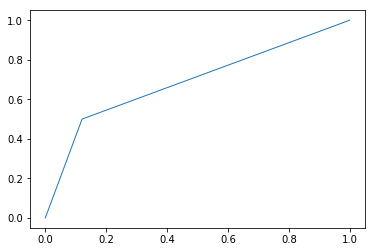

In [123]:
gammas, Cs = [], []
for a in np.r_[-15: 4][::2]:
    gamma = pow(float(2), a)
    gammas.append(gamma)
for b in np.r_[-5: 16][::2]:
    c = pow(float(2), b)
    Cs.append(c)
# Set the parameters by cross-validation  
tuned_parameters = {'kernel': ['rbf'], 'gamma': gammas,  'C': Cs}
tuned_parameters_oc = {'kernel': ['rbf'],'nu':[0.1,0.5], 'gamma': gammas}
black_detection(x, y,0,3000, tuned_parameters_oc, split = 0.8)


In [26]:
epochs = 1000
neuron_num = [297, 500, 297, 100, 50,10, 2]
bs = 4096
get_stat_ANN(x, y,0,500, bs, epochs, neuron_num, split = 0.8, verbose = True)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch 0 completed out of  5000  loss:  1.05576252937
Epoch 1000 completed out of  5000  loss:  1.05576252937
Epoch 2000 completed out of  5000  loss:  1.05576252937
Epoch 3000 completed out of  5000  loss:  1.05576252937
Epoch 4000 completed out of  5000  loss:  1.05576252937
prediction:  [1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1
 1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1
 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
def ann(inputs,bs, epochs, neuron_num,verbose = False ):
    layer_num = len(neuron_num)
    nx = neuron_num[0]
    ny = neuron_num[layer_num - 1]
    weights, biases = {}, {}
    x = tf.placeholder('float32',[None, nx])
    y = tf.placeholder('float32',[None, ny])
    layer_l = x
    for l in range(layer_num - 2):
        input_num = neuron_num[l]
        hidden_num = neuron_num[l + 1]
        weights['h' + str(l+1)] = tf.Variable(tf.random_normal([input_num, hidden_num]))
        biases['b' + str(l+1)] = tf.Variable(tf.random_normal([hidden_num]))

        layer_l = tf.nn.relu(tf.add(tf.matmul(layer_l, weights['h' + str(l+1)]), biases['b' + str(l+1)]))

    weights['out'] = tf.Variable(tf.random_normal([hidden_num, ny]))
    biases['out'] = tf.Variable(tf.random_normal([ny]))
    prediction = tf.nn.softmax(tf.matmul(layer_l, weights['out']) + biases['out'])
    tf.add_to_collection('pred', y)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y))
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        losses, epoches = [],[]
        for epoch in range(epochs):
            epoch_loss=0
            i=0
            while i < len(X_nomalized):
                start = i
                end = i + bs
                batch_x = np.array(X_nomalized[start:end])
                batch_y = np.array(Y[start:end])

                _,c = sess.run([optimizer,cost] , feed_dict = {x: batch_x , y : batch_y})
                if verbose:
                    epoch_loss+= c
                i+= bs
            if (verbose) :
                if (epoch % 1000 == 0):
                    print("Epoch",epoch , 'completed out of ' ,epochs, ' loss: ', epoch_loss )
                losses.append(epoch_loss)
                epoches.append(epoch)

In [14]:
def save_model_ANN(iwl, fh, name, bs, epochs, neuron_num, start_date, end_date,freq, verbose = False):
  classnum = neuron_num[-1]
  X, Y = get_dataframe(name, iwl, fh, start_date, end_date, freq, classnum = classnum, method = 'ANN')
  scaler = preprocessing.StandardScaler().fit(X)
  X_nomalized = scaler.transform(X)

  layer_num = len(neuron_num)
  nx = neuron_num[0]
  ny = neuron_num[layer_num - 1]
  weights, biases = {}, {}
  #get nomalized train and test set


  x = tf.placeholder('float32',[None, nx])
  y = tf.placeholder('float32',[None, ny])
  layer_l = x
  for l in range(layer_num - 2):
    input_num = neuron_num[l]
    hidden_num = neuron_num[l + 1]
    weights['h' + str(l+1)] = tf.Variable(tf.random_normal([input_num, hidden_num]))
    biases['b' + str(l+1)] = tf.Variable(tf.random_normal([hidden_num]))

    layer_l = tf.nn.relu(tf.add(tf.matmul(layer_l, weights['h' + str(l+1)]), biases['b' + str(l+1)]))

  weights['out'] = tf.Variable(tf.random_normal([hidden_num, ny]))
  biases['out'] = tf.Variable(tf.random_normal([ny]))
  prediction = tf.nn.softmax(tf.matmul(layer_l, weights['out']) + biases['out'])
  tf.add_to_collection('pred', y)

  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y))
  optimizer = tf.train.AdamOptimizer().minimize(cost)
  saver = tf.train.Saver()

  with tf.Session() as sess:
      sess.run(tf.initialize_all_variables())
      losses, epoches = [],[]
      for epoch in range(epochs):
          epoch_loss=0
          i=0
          while i < len(X_nomalized):
              start = i
              end = i + bs
              batch_x = np.array(X_nomalized[start:end])
              batch_y = np.array(Y[start:end])

              _,c = sess.run([optimizer,cost] , feed_dict = {x: batch_x , y : batch_y})
              if verbose:
                  epoch_loss+= c
              i+= bs
          if (verbose) :
                if (epoch % 1000 == 0):
                  print("Epoch",epoch , 'completed out of ' ,epochs, ' loss: ', epoch_loss )
                losses.append(epoch_loss)
                epoches.append(epoch)
      path = "./"
      model_name = "ann" + str(classnum) +".ckpt"
      print("model name is : " + model_name)
      saver.save(sess, path + model_name)

Index(['id', 'date', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8',
       ...
       'f288', 'f289', 'f290', 'f291', 'f292', 'f293', 'f294', 'f295', 'f296',
       'f297'],
      dtype='object', length=299)